# Running multiple regression models for the RuBisCO combined dataset

### Following the SeekRank algorithm

In [1]:
import torch
import esm
from transformers import T5Tokenizer, T5EncoderModel
import re
import random
from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [2]:
#Break the array into batches

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

## Preparing the data

In [3]:
concat_all_exp_data = pd.read_pickle('/home/kaustubh/RuBisCO_ML/ESM_LoRA/data/processed_combined_all_exp_assays_data_normalized_wrt_common_ancestors.pkl')
concat_all_exp_data = concat_all_exp_data[concat_all_exp_data['LSU_id'] != "SUMO"]
concat_all_exp_data = concat_all_exp_data[concat_all_exp_data['LSU_id'] != "DEAD"]

### The following is cell is only for working on the initial big assay dataset -- `79 x 34`

In [4]:
only_large_assay = concat_all_exp_data[~concat_all_exp_data['LSU_id'].str.startswith("Anc")]

(array([45., 17.,  5.,  4.,  3.,  5.,  5.,  2.,  2.,  2.,  1.,  0.,  3.,
         5.,  6.,  1.,  4.,  6.,  1.,  6.,  7.,  2.,  4.,  5.,  4.,  7.,
         4.,  3.,  5.,  4.,  6.,  4.,  5.,  3.,  2.,  0.,  2.,  2.,  2.,
         2.,  3.,  1.,  1.,  1.,  0.,  2.,  0.,  0.,  0.,  2.]),
 array([  4.   ,  13.615,  23.23 ,  32.845,  42.46 ,  52.075,  61.69 ,
         71.305,  80.92 ,  90.535, 100.15 , 109.765, 119.38 , 128.995,
        138.61 , 148.225, 157.84 , 167.455, 177.07 , 186.685, 196.3  ,
        205.915, 215.53 , 225.145, 234.76 , 244.375, 253.99 , 263.605,
        273.22 , 282.835, 292.45 , 302.065, 311.68 , 321.295, 330.91 ,
        340.525, 350.14 , 359.755, 369.37 , 378.985, 388.6  , 398.215,
        407.83 , 417.445, 427.06 , 436.675, 446.29 , 455.905, 465.52 ,
        475.135, 484.75 ]),
 <BarContainer object of 50 artists>)

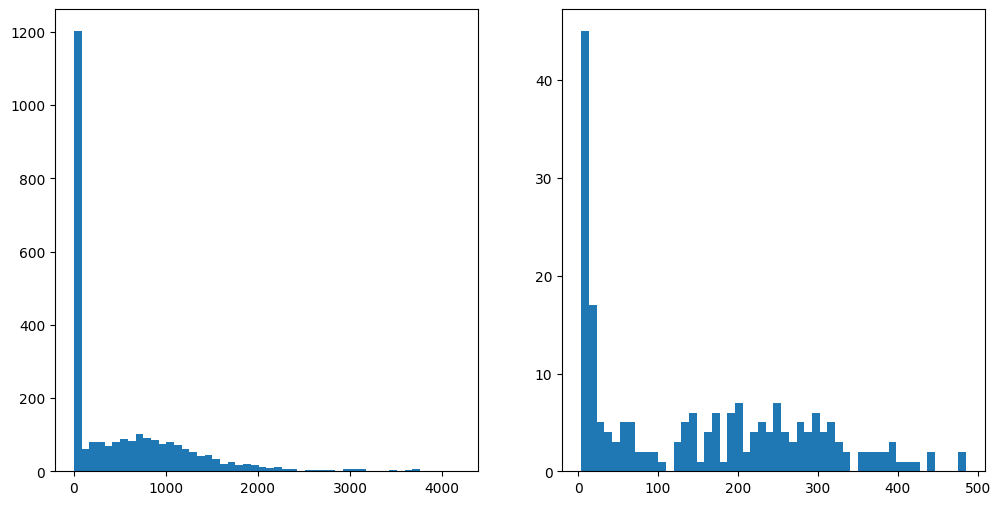

In [5]:
#A side-by-side histogram of "Norm_2" & "mean_reading" column ignoring the NaN values

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(concat_all_exp_data['Norm_2'].dropna(), bins=50)
plt.subplot(1, 2, 2)
plt.hist(concat_all_exp_data['mean_reading'].dropna(), bins=50)

### The experimental activity values are already normalized wrt the vectors and the different Ancestral sequences common between the large & mutant dataset

<Axes: xlabel='log_exp_val', ylabel='Count'>

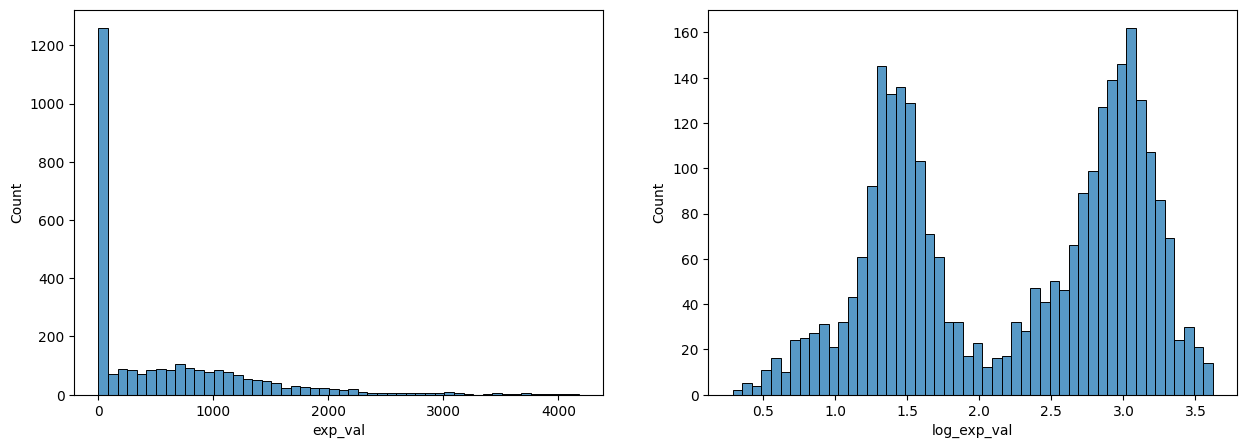

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.histplot(data=concat_all_exp_data, x='exp_val', bins=50, ax=ax[0])
sns.histplot(data=concat_all_exp_data, x='log_exp_val', bins=50, ax=ax[1])

## Building embeddings

In [ ]:
## Calculating ESM-embedding

pretrained_arg = esm.pretrained.esm2_t33_650M_UR50D() ## For ESM-1b: `esm1_t34_670M_UR50S`; ESM-2: `esm2_t33_650M_UR50D()`
layers = 33 ## For ESM-1b: 34; ESM-2: 33

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model.eval()
batch_converter = alphabet.get_batch_converter()
model = model.to(torch.device('cuda:0'))

def compute_esm2_embedding(key, value):

    inp = [(key, value)]
    batch_labels, batch_strs, batch_tokens = batch_converter(inp)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to(torch.device('cuda:0'))
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[layers])
        
    token_representations = results["representations"][layers]
    # return token_representations[0, 0]
    return token_representations[0, 1 : batch_lens[0] - 1].mean(0)


concat_all_exp_data['lsu_esm'] = concat_all_exp_data.apply(lambda x: compute_esm2_embedding(x['LSU_id'], x['lsu_seq']).cpu().numpy() if pd.notna(x['lsu_seq']) else np.nan, axis=1)
concat_all_exp_data['ssu_esm'] = concat_all_exp_data.apply(lambda x: compute_esm2_embedding(x['SSU_id'], x['ssu_seq']).cpu().numpy() if pd.notna(x['ssu_seq']) else np.nan, axis=1)
concat_all_exp_data['lsussu_esm'] = concat_all_exp_data.apply(lambda x: compute_esm2_embedding(x['LSUSSU_id'], x['lsussu_seq']).cpu().numpy() if pd.notna(x['lsussu_seq']) else np.nan, axis=1)

## Generating a weighted average of the LSU and SSU embeddings -- weighted based on the length of the LSU & SSU sequence
concat_all_exp_data['lsu_ssu_weighted_esm'] = concat_all_exp_data.apply(lambda x: np.average((x['lsu_esm'], x['ssu_esm']), axis=0, weights=[
    float(len(x['lsu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq'])), float(len(x['ssu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq']))
    ]) 
    if pd.notna(x['ssu_seq']) else x['lsu_esm'], axis=1)

## Generating a concatenated embedding of LSU and SSU sequences
### If SSU sequence is not available, fill with zeros of the same length as LSU embedding -- using LSU because the size of the embedding will change based on the pLM used
concat_all_exp_data['concatenated_lsu_ssu_emb'] = concat_all_exp_data.apply(lambda x: np.concatenate((x['lsu_esm'], x['ssu_esm'])) if pd.notna(x['ssu_seq']) else np.concatenate((x['lsu_esm'], np.zeros(len(x['lsu_esm'])))), axis=1)

In [ ]:
## Calculating ProtTrans(protT5) as the LLM-embedding

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
# tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
# model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)
    
# if device == torch.device("cpu"):
#     model.to(torch.float32)

# def compute_protT5_embedding(input_sequence):
#     sequence = re.sub(r"[UZOB]", "X", input_sequence)  # Replace U, Z, O, B with X
#     sequence = [" ".join(list(sequence))]  # Add spaces between characters
    
#     ids = tokenizer(sequence, add_special_tokens=True, padding="longest")

#     input_ids = torch.tensor(ids['input_ids']).to(device)
#     attention_mask = torch.tensor(ids['attention_mask']).to(device)

#     with torch.no_grad():
#         embedding_repr = model(input_ids=input_ids, attention_mask=attention_mask)

#     embedding_repr = embedding_repr.last_hidden_state[0,:len(input_sequence)]
#     return embedding_repr.mean(dim=0)

# concat_all_exp_data['lsu_protT5'] = concat_all_exp_data.apply(lambda x: compute_protT5_embedding(x['lsu_seq']).cpu().numpy() if pd.notna(x['lsu_seq']) else np.nan, axis=1)
# concat_all_exp_data['ssu_protT5'] = concat_all_exp_data.apply(lambda x: compute_protT5_embedding(x['ssu_seq']).cpu().numpy() if pd.notna(x['ssu_seq']) else np.nan, axis=1)
# concat_all_exp_data['lsussu_protT5'] = concat_all_exp_data.apply(lambda x: compute_protT5_embedding(x['lsussu_seq']).cpu().numpy() if pd.notna(x['lsussu_seq']) else np.nan, axis=1)

# ## Generating a weighted average of the LSU and SSU embeddings -- weighted based on the length of the LSU & SSU sequence
# concat_all_exp_data['lsu_ssu_weighted_protT5'] = concat_all_exp_data.apply(lambda x: np.average((x['lsu_protT5'], x['ssu_protT5']), axis=0, weights=[
#     float(len(x['lsu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq'])), float(len(x['ssu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq']))
#     ]) 
#     if pd.notna(x['ssu_seq']) else x['lsu_protT5'], axis=1)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
## Calculating ProstTrans(prostT5) as the LLM-embedding

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
# tokenizer = T5Tokenizer.from_pretrained('Rostlab/ProstT5', do_lower_case=False)
# model = T5EncoderModel.from_pretrained("Rostlab/ProstT5").to(device)

# model.float() if device.type=='cpu' else model.half()

# def compute_prostT5_embedding(input_sequence):

#     sequence = re.sub(r"[UZOB]", "X", input_sequence)  # Replace U, Z, O, B with X
#     sequence = [" ".join(list(sequence))]  # Add spaces between characters
#     sequence = [ "<AA2fold>" + " " + s if s.isupper() else "<fold2AA>" + " " + s for s in sequence]
    
#     ids = tokenizer.batch_encode_plus(sequence, add_special_tokens=True, padding="longest", return_tensors='pt').to(device)

#     # input_ids = torch.tensor(ids['input_ids']).to(device)
#     # attention_mask = torch.tensor(ids['attention_mask']).to(device)

#     with torch.no_grad():
#         embedding_repr = model(ids.input_ids, attention_mask=ids.attention_mask)

#     embedding_repr = embedding_repr.last_hidden_state[0,:len(input_sequence)]
#     return embedding_repr.mean(dim=0)

# concat_all_exp_data['lsu_prostT5'] = concat_all_exp_data.apply(lambda x: compute_prostT5_embedding(x['lsu_seq']).cpu().numpy() if pd.notna(x['lsu_seq']) else np.nan, axis=1)
# concat_all_exp_data['ssu_prostT5'] = concat_all_exp_data.apply(lambda x: compute_prostT5_embedding(x['ssu_seq']).cpu().numpy() if pd.notna(x['ssu_seq']) else np.nan, axis=1)
# concat_all_exp_data['lsussu_prostT5'] = concat_all_exp_data.apply(lambda x: compute_prostT5_embedding(x['lsussu_seq']).cpu().numpy() if pd.notna(x['lsussu_seq']) else np.nan, axis=1)

# ## Generating a weighted average of the LSU and SSU embeddings -- weighted based on the length of the LSU & SSU sequence
# concat_all_exp_data['lsu_ssu_weighted_prostT5'] = concat_all_exp_data.apply(lambda x: np.average((x['lsu_prostT5'], x['ssu_prostT5']), axis=0, weights=[
#     float(len(x['lsu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq'])), float(len(x['ssu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq']))
#     ]) 
#     if pd.notna(x['ssu_seq']) else x['lsu_prostT5'], axis=1)

In [26]:
concat_all_exp_data

,od600_2,mScarlet_2,Norm_2,log10_Norm_2,LSU_id,SSU_id,native_pair,lsu_seq,ssu_seq,form,...,std_reading,LSUSSU_id,lsussu_seq,exp_val,log_exp_val,lsu_esm,ssu_esm,lsussu_esm,lsu_ssu_weighted_esm,concatenated_lsu_ssu_emb
0,0.6150,7.0,4.683589,0.670579,330,603,False,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQAYQQSQKTGTFSYLPPMTAEQVTAQIQYCLEKGWAICIEHTEPE...,nonForm_I_entries,...,NaN,330-603,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,4.683589,0.670579,"[0.04298955, 0.0035607752, -0.019734506, -0.08...","[0.014397051, 0.10166579, 0.0043634777, -0.050...","[0.026688656, 0.030369852, -0.020122623, -0.06...","[0.0368665970481332, 0.024569510615820498, -0....","[0.04298955, 0.0035607752, -0.019734506, -0.08..."
1,0.5925,8.0,5.555939,0.744757,330,605,False,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQATQQSSKTSSFSAAAERVLAQIGHCLRKGCVICIEHTPSMAPRF...,nonForm_I_entries,...,NaN,330-605,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,5.555939,0.744757,"[0.04298955, 0.0035607752, -0.019734506, -0.08...","[0.008877339, 0.06041656, 0.025597723, -0.0425...","[0.05942161, 0.018016469, -0.026957061, -0.078...","[0.03589691068645161, 0.015382275132849664, -0...","[0.04298955, 0.0035607752, -0.019734506, -0.08..."
2,0.6212,8.0,5.299249,0.724214,330,607,False,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQTTQATAATASFPAEERMLAQLGHCLRKGCVICIEHTAAMQPRYT...,nonForm_I_entries,...,NaN,330-607,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,5.299249,0.724214,"[0.04298955, 0.0035607752, -0.019734506, -0.08...","[0.009472291, 0.07615884, -0.0067445133, -0.03...","[0.03671648, 0.021743942, -0.027661677, -0.064...","[0.03607328885072281, 0.01854132752244671, -0....","[0.04298955, 0.0035607752, -0.019734506, -0.08..."
3,0.7548,10.0,5.451599,0.736524,330,E1,False,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MAEMQDYKQSLKYETFSYLPPMNAERIRAQIKYAIAQGWSPGIEHV...,nonForm_I_entries,...,NaN,330-E1,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,5.451599,0.736524,"[0.04298955, 0.0035607752, -0.019734506, -0.08...","[0.041855287, 0.06014329, 0.05297826, 0.036349...","[0.02989232, 0.022772914, -0.019962031, -0.054...","[0.042744903660872406, 0.01576484663083273, -0...","[0.04298955, 0.0035607752, -0.019734506, -0.08..."
4,0.4299,5.0,4.785842,0.679958,330,E2,False,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQVWPILNLKKYETLSYLPPLTTDQLARQVDYLLNNKWVPCLEFET...,nonForm_I_entries,...,NaN,330-E2,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,4.785842,0.679958,"[0.04298955, 0.0035607752, -0.019734506, -0.08...","[0.016487531, 0.109111644, 0.015157939, 0.0581...","[0.0492836, 0.015711924, -0.024560945, -0.0596...","[0.036756760374879745, 0.02838440215923818, -0...","[0.04298955, 0.0035607752, -0.019734506, -0.08..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911,NaN,NaN,NaN,NaN,Anc510_mutant_cluster_95,SSU_510,NaN,MQTQTQTKAGYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,MQTLPKERRFETFSYLPPLSDEQIAKQIQYILDQGWIPAIEFSESS...,NaN,...,26.318561,Anc510_mutant_cluster_95-SSU_510,MQTQTQTKAGYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,478.803346,2.680157,"[0.011621219, 0.084632024, -0.01828115, -0.036...","[0.036390934, 0.08527322, 0.016811753, 0.01215...","[0.040780246, 0.068368085, -0.031451806, -0.02...","[0.015517177170446253, 0.08473287621703844, -0...","[0.011621219, 0.084632024, -0.01828115, -0.036..."
2912,NaN,NaN,NaN,NaN,Anc510_mutant_cluster_96,SSU_510,NaN,MQTQTQTKAMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,MQTLPKERRFETFSYLPPLSDEQIAKQIQYILDQGWIPAIEFSESS...,NaN,...,35.336478,Anc510_mutant_cluster_96-SSU_510,MQTQTQTKAMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,1760.306417,3.245588,"[0.0095866835, 0.08347685, -0.0150982225, -0.0...","[0.036390934, 0.08527322, 0.016811753, 0.01215...","[0.041344862, 0.06536592, -0.03095076, -0.0251...","[0.013808740298882814, 0.08375980348643884, -0...","[0.0095866835, 0.08347685, -0.0150982225, -0.0..."
2913,NaN,NaN,NaN,NaN,Anc510_mutant_cluster_97,SSU_510,NaN,MQTQTQTKAMYQAGVKDYRETYYTPD

In [27]:
repeat_entries = ["Anc365", "Anc366", "Anc367", "Anc393", "Anc509"]
concat_all_exp_data = concat_all_exp_data[~concat_all_exp_data['LSU_id'].isin(repeat_entries)]

## Creating Training -- large dataset and Test set -- mutant dataset

In [ ]:
Xs = []
ys = []
data = []
headers = []

for i, row in concat_all_exp_data.iterrows():
    header = row['LSUSSU_id']
    headers.append(header)
    sequence = row['lsussu_seq']
    data.append((header, sequence))
    ys.append(row['log_exp_val'])
    # Xs.append(row['lsu_ssu_weighted_esm'])  ## Using the weighted LSU-SSU ESM embeddings
    Xs.append(row['lsussu_esm'])  ## Using the concatenated LSU-SSU ESM embeddings
    # Xs.append(row['lsu_ssu_weighted_protT5'])  ## Using the weighted LSU-SSU protT5 embeddings
    # Xs.append(row['lsu_ssu_weighted_prostT5'])  ## Using the weighted LSU-SSU prostT5 embeddings

In [38]:
# # Creating Training and Test set, making sure there are no RbcL repeats in the training and test set
def generate_train_test(Xs, ys, headers, random_seed, fraction=0.8):
    lsu_list = [x.split("-")[0] for x in headers]
    lsu_list_uniq = pd.Series(lsu_list).unique().copy()
    random.seed(random_seed)
    random.shuffle(lsu_list_uniq)
    train_size = int(len(lsu_list_uniq) * fraction)
    train_set = lsu_list_uniq[:train_size]
    test_set = lsu_list_uniq[train_size:]
    train_indices = [i for i, x in enumerate(lsu_list) if x in train_set]
    test_indices = [i for i, x in enumerate(lsu_list) if x in test_set]

    Xs_train = [Xs[i] for i in train_indices]
    Xs_test = [Xs[i] for i in test_indices]
    ys_train = [ys[i] for i in train_indices]
    ys_test = [ys[i] for i in test_indices]
    return train_indices, test_indices, train_set, test_set, Xs_train, Xs_test, ys_train, ys_test

train_indices, test_indices, train_ids, test_ids, Xs_train, Xs_test, ys_train, ys_test = generate_train_test(Xs, ys, headers, 42)

In [ ]:
## Creating Training and Test set, such that the data from the large assay is in training & from the mutant assay is in test

# test_indices = [i for i, x in enumerate(headers) if x.startswith("Anc")]
# train_indices = [i for i, x in enumerate(headers) if i not in test_indices]

# Xs_train = [Xs[i] for i in train_indices]
# Xs_test = [Xs[i] for i in test_indices]
# ys_train = [ys[i] for i in train_indices]
# ys_test = [ys[i] for i in test_indices]

In [ ]:
## Creating Training and Test set, such that the data from the mutant assay is in training & from the large assay is in testing
### The idea is that we have better resolution in the mutant dataset

# train_indices = [i for i, x in enumerate(headers) if x.startswith("Anc")]
# test_indices = [i for i, x in enumerate(headers) if i not in train_indices]

# Xs_train = [Xs[i] for i in train_indices]
# Xs_test = [Xs[i] for i in test_indices]
# ys_train = [ys[i] for i in train_indices]
# ys_test = [ys[i] for i in test_indices]

In [39]:
len(train_indices), len(test_indices)

(2167, 712)

## Training block

In [40]:
ridge_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

lasso_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'selection': ['cyclic', 'random'],
    'max_iter': [1000, 5000]
}

elasticnet_grid = {
    'alpha': [0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.5, 0.9],
    'max_iter': [1000, 5000]
}

knn_grid = {
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [15, 30],
    'p' : [1, 2],
}

svm_grid = {
    'C' : [0.1, 1.0, 10.0],
    'kernel' :['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [3],
    'gamma': ['scale'],
}

rfr_grid = {
    'n_estimators' : [100],
    'criterion' : ['squared_error', 'absolute_error'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split' : [2, 10],
    'min_samples_leaf': [1, 4]
}

gbr_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'loss': ['squared_error', 'absolute_error']
}

xgb_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

mlp_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam','lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000]
}

In [41]:
cls_list = [Ridge, Lasso, ElasticNet, KNeighborsRegressor, SVR, RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, MLPRegressor]
param_grid_list = [ridge_grid, lasso_grid, elasticnet_grid, knn_grid, svm_grid, rfr_grid, gbr_grid, xgb_grid, mlp_grid]
result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = cls_name(),
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.linear_model._ridge.Ridge'>
Fitting 5 folds for each of 20 candidates, totalling 100 fits
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
Fitting 5 folds for each of 18 candidates, totalling 90 fits
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits
<class 'sklearn.svm._classes.SVR'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits
<class 'xgboost.sklearn.XGBRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits
<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
Fitting 5 folds for each of 

/home/kaustubh/miniforge3/envs/rubisco_regressor_protT5/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/kaustubh/miniforge3/envs/rubisco_regressor_protT5/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/kaustubh/miniforge3/envs/rubisco_regressor_protT5/lib/python3.13/site-packages/sklearn

In [42]:
grid_list

[GridSearchCV(estimator=Ridge(), n_jobs=-1,
              param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
                          'solver': ['auto', 'svd', 'cholesky', 'lsqr']},
              scoring='r2', verbose=1),
 GridSearchCV(estimator=Lasso(), n_jobs=-1,
              param_grid={'alpha': [0.01, 0.1, 1.0, 10.0],
                          'max_iter': [1000, 5000],
                          'selection': ['cyclic', 'random']},
              scoring='r2', verbose=1),
 GridSearchCV(estimator=ElasticNet(), n_jobs=-1,
              param_grid={'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9],
                          'max_iter': [1000, 5000]},
              scoring='r2', verbose=1),
 GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [15, 30], 'n_neighbors': [5, 10],
                          'p': [1, 2], 'weights': ['uniform', 'distance']},
              

## Testing the trained model 

Ridge(alpha=0.01, solver='svd')
Spearman's rho: 0.58, R^2: 0.17, MAE: 0.63, MSE: 0.60, RMSE: 0.78

Lasso(alpha=0.01)
Spearman's rho: 0.26, R^2: 0.10, MAE: 0.72, MSE: 0.65, RMSE: 0.81

ElasticNet(alpha=0.01, l1_ratio=0.1)
Spearman's rho: 0.50, R^2: 0.24, MAE: 0.64, MSE: 0.55, RMSE: 0.74

KNeighborsRegressor(algorithm='ball_tree', leaf_size=15, p=1,
                    weights='distance')


Spearman's rho: 0.61, R^2: 0.41, MAE: 0.52, MSE: 0.43, RMSE: 0.65

SVR(C=10.0, kernel='linear')
Spearman's rho: 0.62, R^2: 0.26, MAE: 0.58, MSE: 0.54, RMSE: 0.73

RandomForestRegressor(max_features='log2')
Spearman's rho: 0.71, R^2: 0.48, MAE: 0.52, MSE: 0.38, RMSE: 0.61

GradientBoostingRegressor(learning_rate=0.2, max_depth=5)
Spearman's rho: 0.34, R^2: -0.03, MAE: 0.69, MSE: 0.75, RMSE: 0.87

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, miss

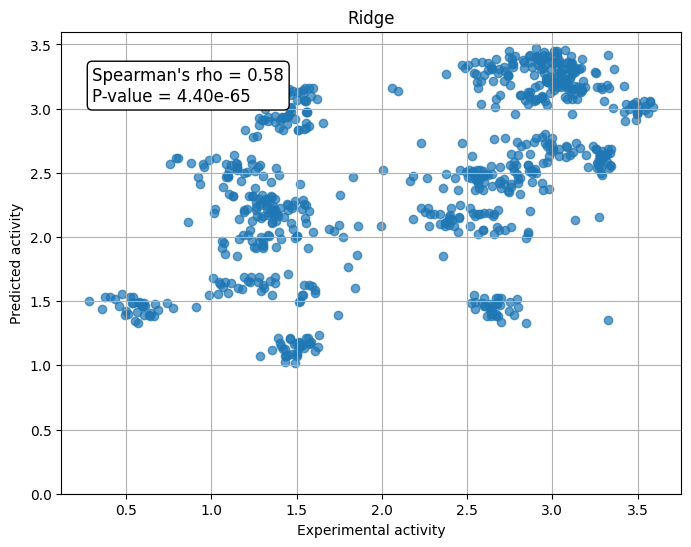

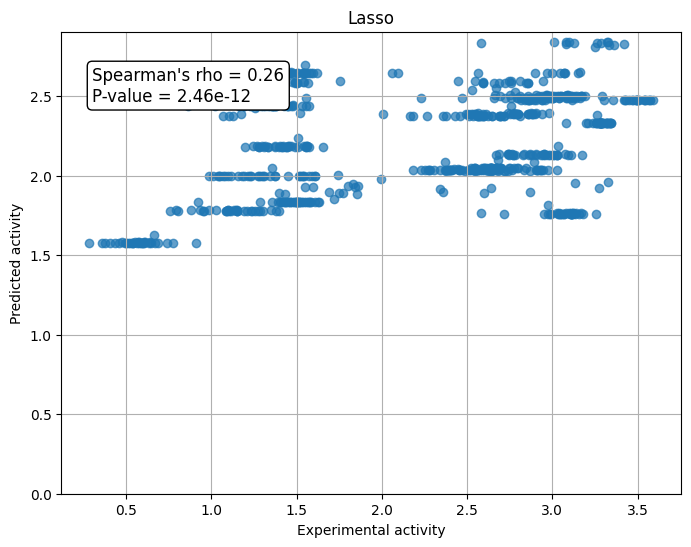

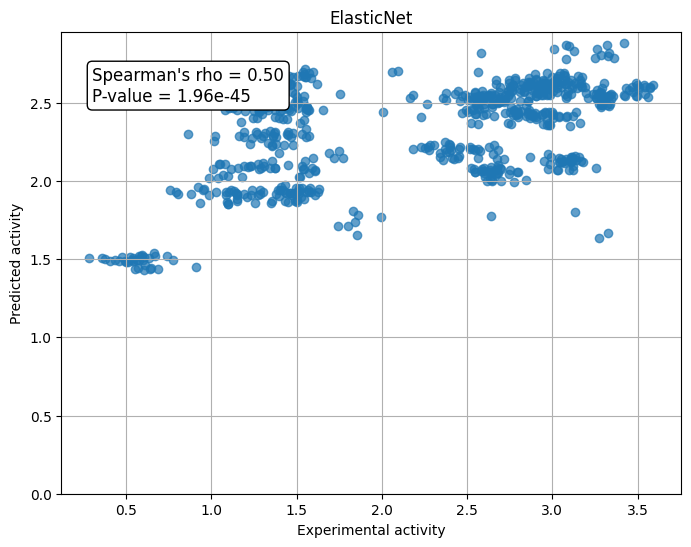

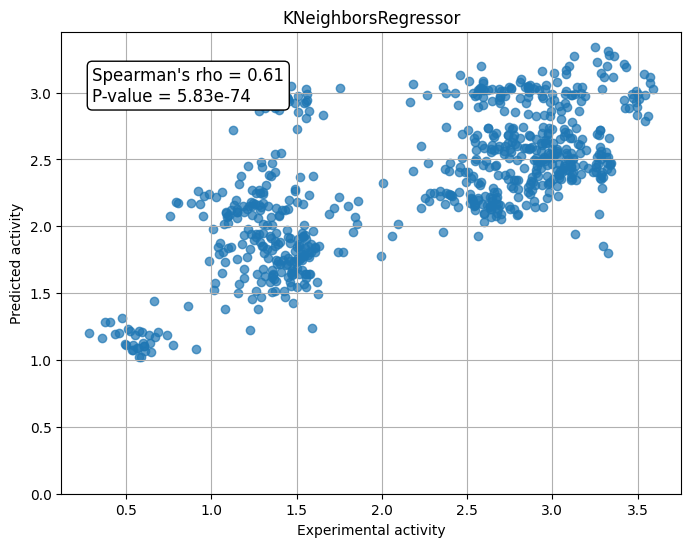

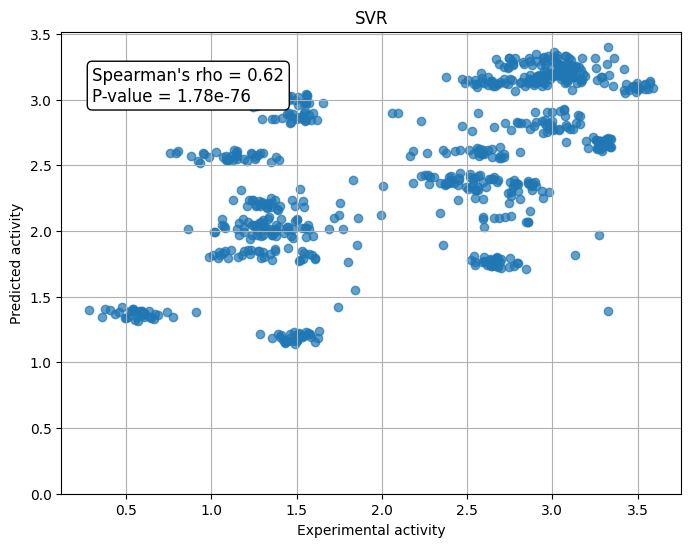

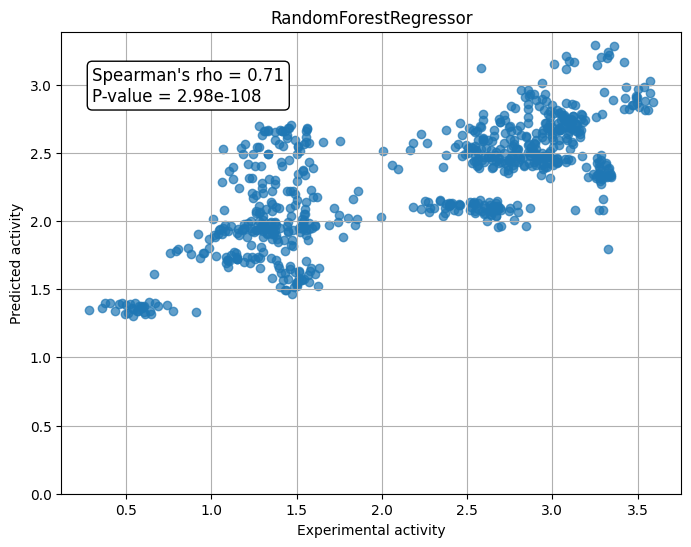

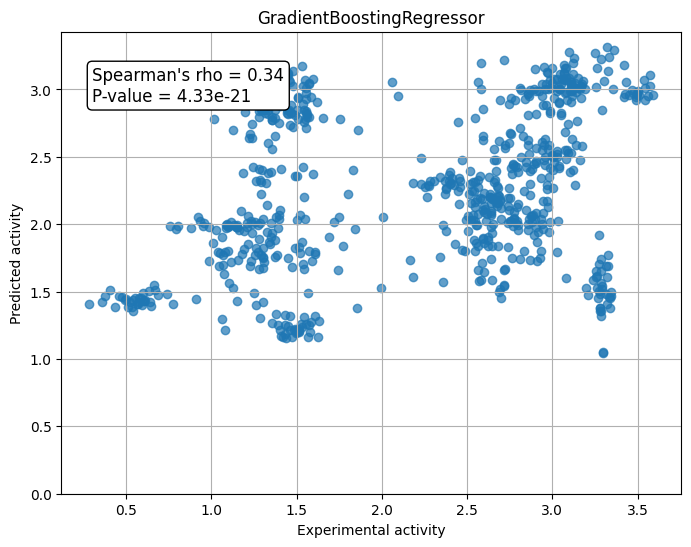

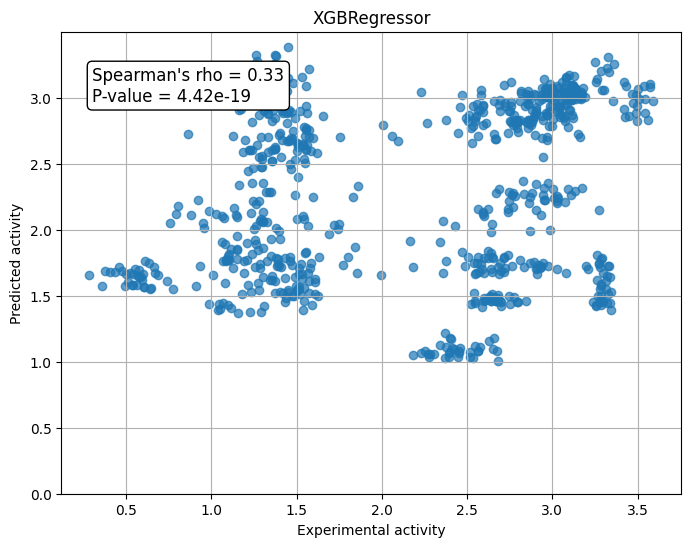

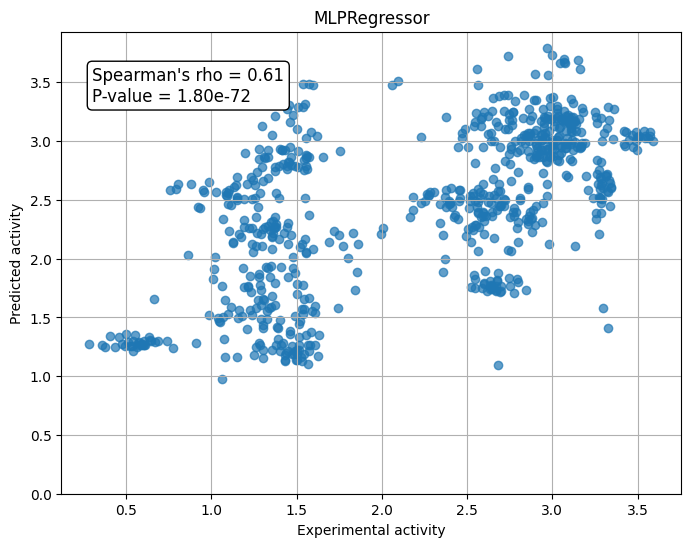

In [43]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

performance_metrics = {
    'model':[],
    'spearman_rho':[],
    'r2':[],
    'mae':[],
    'mse':[],
    'rmse':[]
}
for i, grid in enumerate(grid_list):
    print(grid.best_estimator_)
    var = grid.best_estimator_.__class__.__name__

    model_file_name = f'/home/kaustubh/RuBisCO_ML/regressor_models/data/regressor_output/normalized_wrt_ind_ancs/LSUSSU_ESM2_log_all_data_split/grid_element_best_{var}_model.pkl'
    # Save the model
    with open(model_file_name, 'wb') as f:
        pickle.dump(grid.best_estimator_, f)

    # Predictions
    preds = grid.predict(Xs_test)

    # Computing different performance metrics
    rho, p_value = scipy.stats.spearmanr(ys_test, preds)
    r2 = r2_score(ys_test, preds)
    mae = mean_absolute_error(ys_test, preds)
    mse = mean_squared_error(ys_test, preds)
    rmse = np.sqrt(mse)

    performance_metrics['model'].append(var)
    performance_metrics['spearman_rho'].append(rho)
    performance_metrics['r2'].append(r2)
    performance_metrics['mae'].append(mae)
    performance_metrics['mse'].append(mse)
    performance_metrics['rmse'].append(rmse)
    print(f'Spearman\'s rho: {rho:.2f}, R^2: {r2:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}')
    print()

    # Create a DataFrame and save to CSV
    df = pd.DataFrame({'Experimental Activity': ys_test, 'Predicted Activity': preds})
    csv_filename = f'/home/kaustubh/RuBisCO_ML/regressor_models/data/regressor_output/normalized_wrt_ind_ancs/LSUSSU_ESM2_log_all_data_split/grid_element_test_set_{var}_activity_data.csv'
    df.to_csv(csv_filename, index=False)
    # print(f'Data saved to {csv_filename}')

    plt.figure(figsize=(8, 6))
    plt.scatter(ys_test, preds, alpha=0.7)
    plt.ylim(0,)
    plt.title(var)
    plt.xlabel('Experimental activity')
    plt.ylabel('Predicted activity')
    plt.grid(True)

    plt.annotate(f'Spearman\'s rho = {rho:.2f}\nP-value = {p_value:.2e}',
                 xy=(0.05, 0.85), xycoords='axes fraction',
                 fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

In [44]:
performance_metrics_df = pd.DataFrame(performance_metrics)
performance_metrics_df.to_csv('/home/kaustubh/RuBisCO_ML/regressor_models/data/regressor_output/normalized_wrt_ind_ancs/LSUSSU_ESM2_log_all_data_split/performance_metrics.csv', index=False)